In [1]:
#import
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


In [2]:
#data
pd.set_option('mode.chained_assignment', None)
ticker = "TSLA"
start_date = "2025-01-01"

In [3]:
try:
    data = yf.download(ticker, start=start_date, auto_adjust=True)

    if data.empty:
        raise ValueError(f"No data retrieved for ticker: {ticker}")

    data = data.reset_index()

    if len(data.columns) == 6:
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    else:
        data.columns = [str(col).replace(' ', '_').replace('-', '_') for col in data.columns]

    data = data.dropna()

except Exception as e:
    exit()

[*********************100%***********************]  1 of 1 completed


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['dayofweek'] = data['Date'].dt.dayofweek
data['day'] = data['Date'].dt.day


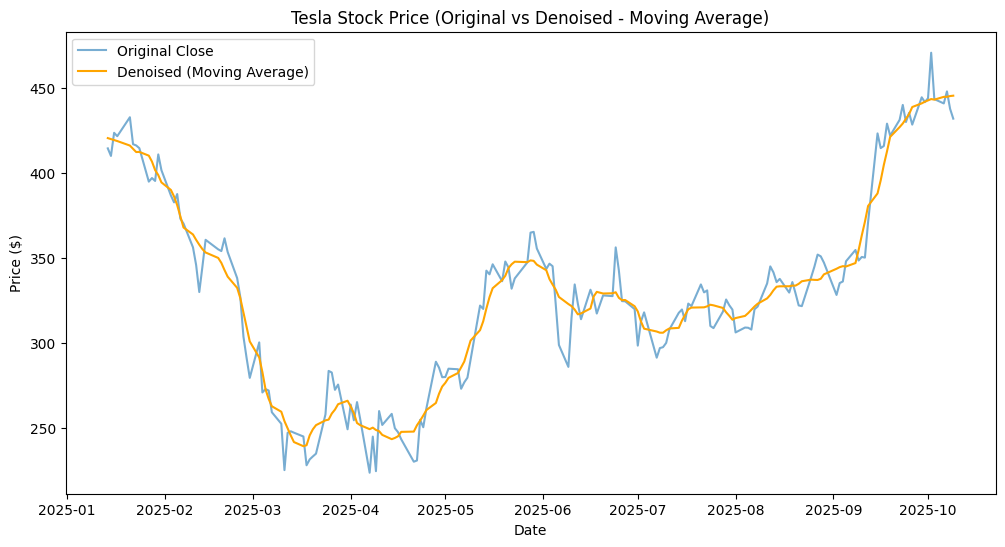

In [7]:

data['Close_denoised'] = data['Close'].rolling(window=10, center=True, min_periods=1).mean()
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Original Close', alpha=0.6)
plt.plot(data['Date'], data['Close_denoised'], label='Denoised (Moving Average)', color='orange')
plt.title("Tesla Stock Price (Original vs Denoised - Moving Average)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [18]:
# Target: 7-day percentage return
data['target_return_t+7'] = (data['Close_denoised'].shift(-7) - data['Close_denoised']) / data['Close_denoised']

In [20]:
 #Lag features
data['previous_return_1d'] = data['Close_denoised'].pct_change().shift(1)
data['previous_return_2d'] = data['Close_denoised'].pct_change().shift(2)
data['previous_return_5d_avg'] = data['Close_denoised'].pct_change().shift(1).rolling(window=5).mean()

for lag in range(1, 8):
    data[f'lag_price_{lag}'] = data['Close_denoised'].shift(lag)

data = data.dropna().reset_index(drop=True)

features = [col for col in data.columns if
            col.startswith('lag_price_') or col.startswith('previous_return_') or col in [
                'Open', 'High', 'Low', 'Volume', 'year', 'month', 'dayofweek', 'day'
            ]]
target = 'target_return_t+7'


In [21]:
# data models
X = data[features]
y = data[target]


In [23]:
 # TrainTest Split
test_size = 0.2
split_point = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]
X_test_dates = data['Date'].iloc[split_point:]


In [24]:
# Model Training
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
#fit model/predict
xgb_model.fit(X_train, y_train)

y_pred_returns = xgb_model.predict(X_test)

last_actual_price = data['Close_denoised'].iloc[y_test.index - 1].reset_index(drop=True)
predicted_price = last_actual_price * (1 + y_pred_returns)
actual_price = data['Close_denoised'].iloc[y_test.index].reset_index(drop=True)

mae_price = mean_absolute_error(actual_price, predicted_price)
rmse_price = np.sqrt(mean_squared_error(actual_price, predicted_price))
r2_return = r2_score(y_test, y_pred_returns)

print(f"R-squared (R2) Score on Returns: {r2_return:.4f}")
print(f"Mean Absolute Error (MAE) on Price: {mae_price:.4f} USD")
print(f"Root Mean Squared Error (RMSE) on Price: {rmse_price:.4f} USD")


R-squared (R2) Score on Returns: -4.3055
Mean Absolute Error (MAE) on Price: 16.2466 USD
Root Mean Squared Error (RMSE) on Price: 16.9175 USD


In [27]:
# Metrics
mae_price = mean_absolute_error(actual_price, predicted_price)
rmse_price = np.sqrt(mean_squared_error(actual_price, predicted_price))
r2_return = r2_score(y_test[-len(y_pred_returns):], y_pred_returns)

print(f"R-squared (R2) Score on 7-Day Returns: {r2_return:.4f}")
print(f"Mean Absolute Error (MAE) on 7-Day Price: {mae_price:.4f} USD")
print(f"Root Mean Squared Error (RMSE) on 7-Day Price: {rmse_price:.4f} USD")

R-squared (R2) Score on 7-Day Returns: -4.3055
Mean Absolute Error (MAE) on 7-Day Price: 16.2466 USD
Root Mean Squared Error (RMSE) on 7-Day Price: 16.9175 USD


In [28]:
#  Results DataFrame
results_df = pd.DataFrame({
    'Date': X_test_dates[-len(predicted_price):],
    'Actual Price (t+7)': actual_price,
    'Predicted Price (t+7)': predicted_price
}).set_index('Date')


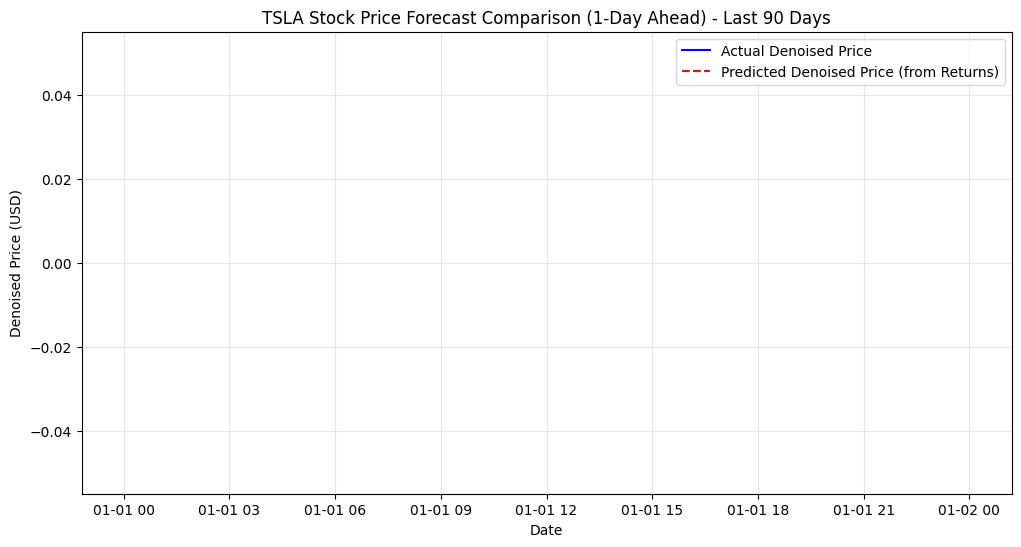

In [31]:
#  Plot
results_df = pd.DataFrame({
    'Date': X_test_dates,
    'Actual Price (t+1)': actual_price,
    'Predicted Price (t+1)': predicted_price
}).set_index('Date')

plot_df = results_df.tail(90)

plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual Price (t+1)'], label='Actual Denoised Price', color='blue')
plt.plot(plot_df.index, plot_df['Predicted Price (t+1)'], label='Predicted Denoised Price (from Returns)', color='red',
         linestyle='--')
plt.title(f'{ticker} Stock Price Forecast Comparison (1-Day Ahead) - Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Denoised Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()